In [1]:
import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config

set_config(display='diagram') # Useful for display the pipeline

print("Pandas  ", pd.__version__)

Pandas   1.2.4


In [2]:
CLOUD = False

if CLOUD:
    import os
    os.environ['KAGGLE_USERNAME'] = "your_kaggle_username"
    os.environ['KAGGLE_KEY']      = "your_kaggle_api_key"  # See https://www.kaggle.com/docs/api
    !pip install --upgrade kaggle
    !kaggle competitions download -c titanic
    DATA_PATH = "./"

else:
    DATA_PATH = "../../Datasets/Tabular/titanic/"

In [22]:
df      = pd.read_csv(DATA_PATH + "train.csv", index_col='PassengerId')
df_test = pd.read_csv(DATA_PATH + "test.csv",  index_col='PassengerId')

print("Train DataFrame:", df.shape)
print("Test DataFrame: ", df_test.shape)

Train DataFrame: (891, 11)
Test DataFrame:  (418, 10)


# fe 1: title

In [23]:
get_Title_from_Name = lambda name: name.split(',')[1].split('.')[0].strip()

df['Title']      = df['Name'].map(get_Title_from_Name)
df_test['Title'] = df_test['Name'].map(get_Title_from_Name)

In [24]:
df['Title']

PassengerId
1        Mr
2       Mrs
3      Miss
4       Mrs
5        Mr
       ... 
887     Rev
888    Miss
889    Miss
890      Mr
891      Mr
Name: Title, Length: 891, dtype: object

In [27]:
title_dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    'Dona':'Royalty',
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

In [28]:
df['Title'] = df.Title.map(title_dictionary)
df_test['Title'] = df_test.Title.map(title_dictionary)

# FE 2

In [29]:
df['Cabin'].value_counts()

B96 B98        4
C23 C25 C27    4
G6             4
C22 C26        3
D              3
              ..
A19            1
B41            1
B4             1
D7             1
B94            1
Name: Cabin, Length: 147, dtype: int64

In [30]:
df['Deck'] = df['Cabin'].str[0]

In [32]:
df['Deck'].isnull().sum()/len(df)

0.7710437710437711

# FE3

In [34]:
df['Family_Size'] = df['SibSp']+df['Parch']

In [36]:
df['Family_Size'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family_Size, dtype: int64

# FE4

In [41]:
df['Age*Class']=df['Age']*df['Pclass']

<AxesSubplot:xlabel='Survived', ylabel='Age*Class'>

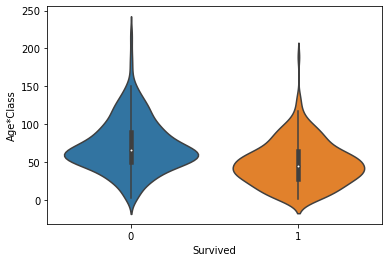

In [42]:
sb.violinplot(x='Survived', y='Age*Class', data=df)

# FE5

In [43]:
df['Fare_Per_Person']=df['Fare']/(df['Family_Size']+1)

# Split num and cat

In [56]:
cat_vars  = ['Sex', 'Embarked', 'Title', 'Deck']        
num_vars  = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age','Family_Size', 'Age*Class', 'Fare_Per_Person'] 

print("\nNumerical features:\n", num_vars)
print("\nCategorical features:\n", cat_vars)

x = df[cat_vars + num_vars]
y = df.Survived


Numerical features:
 ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age', 'Family_Size', 'Age*Class', 'Fare_Per_Person']

Categorical features:
 ['Sex', 'Embarked', 'Title', 'Deck']


# Train

In [47]:
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.experimental  import enable_hist_gradient_boosting # Necesary for HistGradientBoostingClassifier
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier

In [51]:
num_4_treeModels = pipeline.Pipeline(steps=[
  ('imputer', impute.SimpleImputer(strategy='constant', fill_value=-9999,add_indicator=True)) 
])

cat_4_treeModels = pipeline.Pipeline(steps=[
  ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
  ('ordinal', preprocessing.OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan))
])

tree_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_4_treeModels, num_vars),
    ('cat', cat_4_treeModels, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

#tree_classifiers = {name: pipeline.make_pipeline(tree_prepro, model) for name, model in tree_classifiers.items()}

tree_prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value=-9999,
                                                                strategy='constant'))]),
                                 ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age',
                                  'Family_Size', 'Age*Class',
                                  'Fare_Per_Person']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan))]),
                                 ['Sex', 'Embarked', 'Title', 'Deck'])])

In [54]:
pipe = pipeline.make_pipeline(tree_prepro, LGBMClassifier())
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value=-9999,
                                                                                 strategy='constant'))]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age', 'Family_Size',
                                                   'Age*Class',
                                                   'Fare_Per_Person']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['Sex', 'Embarked', 'Title',
                                                   'Deck'])])),
                ('lgbmclassifier', LGBMClassifier())])

In [57]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x, y,
    test_size=0.2,
    stratify = y,
    random_state=4)

In [58]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value=-9999,
                                                                                 strategy='constant'))]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age', 'Family_Size',
                                                   'Age*Class',
                                                   'Fare_Per_Person']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['Sex', 'Embarked', 'Title',
                                                   'Deck'])])),
                ('lgbmclassifier', LGBMClassifier())])

In [77]:
all_pred = model_selection.cross_val_predict(pipe, x,y,cv=50)

In [78]:
all_pred

array([1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,

In [66]:
fi = pipe[1].feature_importances_
fi

In [63]:
x.columns.values.tolist()

['Sex',
 'Embarked',
 'Title',
 'Deck',
 'Pclass',
 'SibSp',
 'Parch',
 'Fare',
 'Age',
 'Family_Size',
 'Age*Class',
 'Fare_Per_Person']

In [68]:
feature_imp = pd.DataFrame(sorted(zip(fi, x.columns.values.tolist())), columns=['Value','Feature'])
feature_imp

,Value,Feature
0,0,Family_Size
1,3,Age
2,26,Title
3,31,Embarked
4,49,Sex
5,57,SibSp
6,72,Fare_Per_Person
7,78,Age*Class
8,411,Parch
9,560,Fare


In [71]:
from sklearn.inspection import permutation_importance
r = permutation_importance(pipe, x_val, y_val,
                            n_repeats=30,
                            random_state=0)

In [ ]:
r

In [74]:
sorted_idx = r.importances_mean.argsort()
sorted_idx

array([ 3,  5,  6,  9,  1,  7, 10, 11,  8,  4,  2,  0])

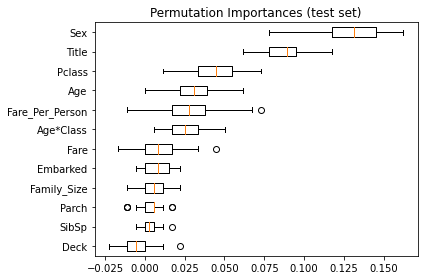

In [75]:
fig,ax = plt.subplots()
ax.boxplot(r.importances[sorted_idx].T, vert=False, labels=x.columns[sorted_idx])
ax.set_title('Permutation Importances (test set)')
fig.tight_layout()
plt.show()